# **1. Introduction** <a class="anchor" id="1"></a>

## **1.2. Import packages**

In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

## **1.3. Import data**

In [4]:
data = pd.read_excel("Datasets/Train.xlsx")

In [ ]:
#   Group A -  The majority of the people (volunteers) were carefully chosen through an extensive selection process
#   Group B -  More than 2500 people were payed to participate in the mission (those were people who have been considered 
#              by the state has essential people to have on an initial stage)
#   Group C -  Around 1500 people payed to participate in the mission 
#             (those who were rejected in a selection process but entered by making a money offer)

#probably relative to ticket price(GroupC) and money_received(GroupB) --> we need to check if the numbers are in order with info

In [5]:
data.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


# **2. Data preprocessing** <a class="anchor" id="3"></a>

In [6]:
df = data.copy()
#to make it easier to work with columns
df.columns = df.columns.str.replace(' ', '_', regex=True)
#converting column datatype to str to use string manipulation
df['Name'] = df['Name'].astype(str)
#first string before .
df['Name_gender'] = df['Name'].str.split('.').str[0]
#in order to dont miss out on anyone that hasnt a Mr or Mrs 
df['Name_gender'] = df['Name_gender'].replace(' ', '.', regex=True)
df['Name_gender'] = df['Name_gender'].str.split('.').str[0]
# 1 to female and 0 to male
def binary_gender(x):
    if str(x) == 'Mrs' or str(x) == 'Miss':
        return 'Female'
    else:
        return 'Male'
df['Name_gender'] = df['Name_gender'].apply(binary_gender)

df.rename(columns = {'Name_gender':'Sex'}, inplace = True)

In [7]:
#converting Birthday to years(int)
df['Birthday'] = df['Birthday'].astype(str)
df['Age'] = df['Birthday'].str.split(',').str[1]
df['Age'] = df["Age"].apply(lambda x : 2046 - int(x))

In [8]:
# delete un-necessary columns
del df['Name']
del df['Birthday']
del df['CITIZEN_ID']

In [9]:
df = df[np.insert(df.columns[:-1].values, 0, df.columns[-1], axis=None)]

In [82]:
# Lets combine education level into highest level of education
edu_level = ['Middle School', 'High School', 'Professional School', 'Bachelors', 'Masters']
for edu in edu_level:
    mask = df['Education_Level'].str.contains(edu ,na = False)
    df.loc[mask, 'Education_Level'] = df.loc[mask, 'Education_Level'].apply(lambda x: edu)

## Missing values

In [83]:
#for non metric features, replace '?' with NaN value to easily detect
def converting_nan(x):
    if str(x) == '?':
        return np.nan
    else:
        return x
df['Base_Area'] = df['Base_Area'].apply(converting_nan)
df['Employment_Sector'] = df['Employment_Sector'].apply(converting_nan)
df['Education_Level'] = df['Education_Level'].apply(converting_nan)
df['Role'] = df['Role'].apply(converting_nan)

In [84]:
# Fill NaN values in categorical features using mode
contain_NA_feats = ['Base_Area', 'Employment_Sector', 'Role']
modes = df[contain_NA_feats].mode().loc[0]
df.fillna(modes,inplace = True)

In [85]:
df.isna().sum()

Age                       0
Native_Continent          0
Marital_Status            0
Lives_with                0
Base_Area                 0
Education_Level           0
Years_of_Education        0
Employment_Sector         0
Role                      0
Working_Hours_per_week    0
Money_Received            0
Ticket_Price              0
Income                    0
Sex                       0
dtype: int64

## Separate numercial & categorical variables; independent & dependent variables

In [86]:
# Separate Dependent & Independent feature:
df_Y = df.loc[:,'Income']
df_X = df.drop('Income', axis = 1)
# indicate categorical & numbercial feature
numercial = [feat for feat in df_X.columns if df_X[feat].dtype!='O']
categorical = [feat for feat in df_X.columns if df_X[feat].dtype =='O']

## Explore data by each predefined groups (A, B & C)

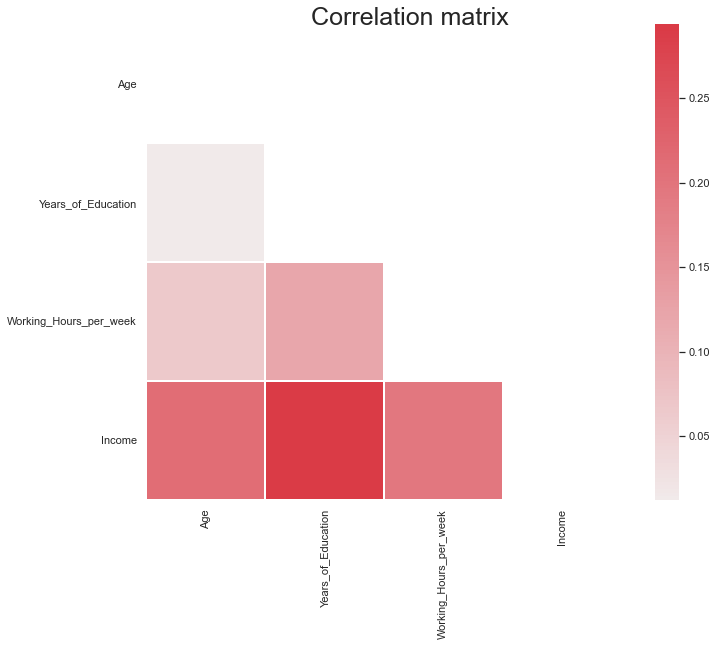

In [88]:
sns.set(style="white")

# Compute the correlation matrix
corr = data_groupA.corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=25)
plt.yticks(rotation=0)


plt.show()

In [87]:
#   Group A -  The majority of the people (volunteers) were carefully chosen through an extensive selection process
#   Group B -  More than 2500 people were payed to participate in the mission (those were people who have been considered 
#              by the state has essential people to have on an initial stage)
#   Group C -  Around 1500 people payed to participate in the mission 
#             (those who were rejected in a selection process but entered by making a money offer)

#probably relative to ticket price(GroupC) and money_received(GroupB) --> we need to check if the numbers are in order with info

# Separate data of group A & B & C
data_groupA = df[(df['Money_Received'] == 0) & (df['Ticket_Price'] == 0)].drop(['Money_Received','Ticket_Price'],axis = 1)
data_groupB = df[df['Money_Received'] != 0].drop('Ticket_Price',axis = 1)
data_groupC = df[df['Ticket_Price'] != 0].drop('Money_Received', axis = 1)

### Group A

# **4. Modeling** <a class="anchor" id="4"></a>

### Group B

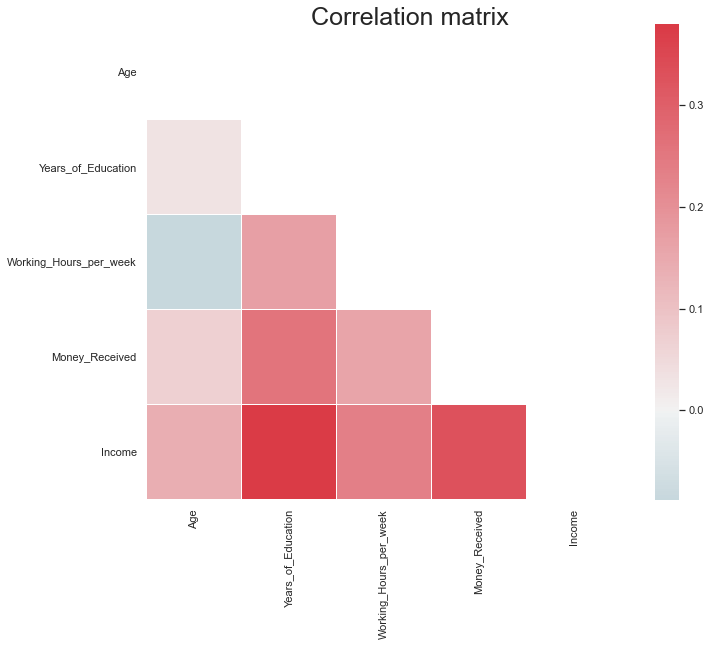

In [89]:
sns.set(style="white")

# Compute the correlation matrix
corr = data_groupB.corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=25)
plt.yticks(rotation=0)


plt.show()

### Group C

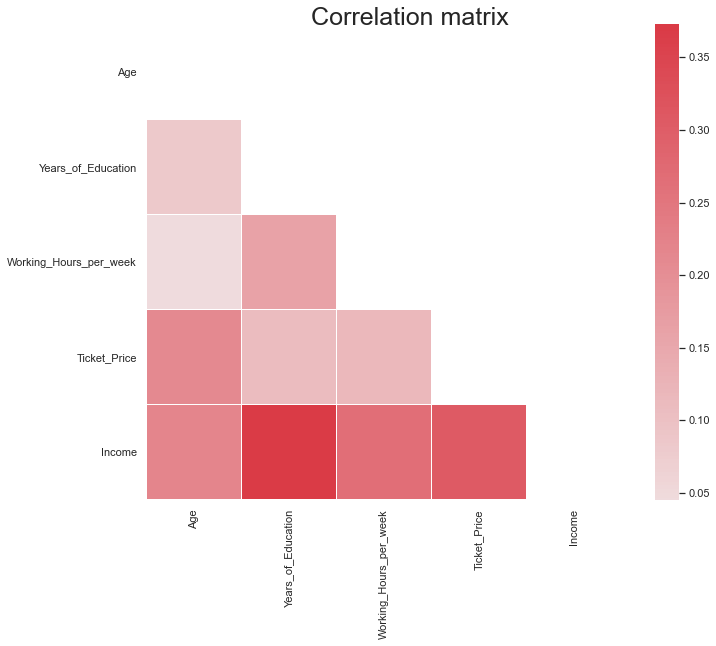

In [90]:
sns.set(style="white")

# Compute the correlation matrix
corr = data_groupC.corr() #Getting correlation of numerical variables

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=25)
plt.yticks(rotation=0)


plt.show()

## Explore categorical variable

In [91]:
categorical

['Native_Continent',
 'Marital_Status',
 'Lives_with',
 'Base_Area',
 'Education_Level',
 'Employment_Sector',
 'Role',
 'Sex']

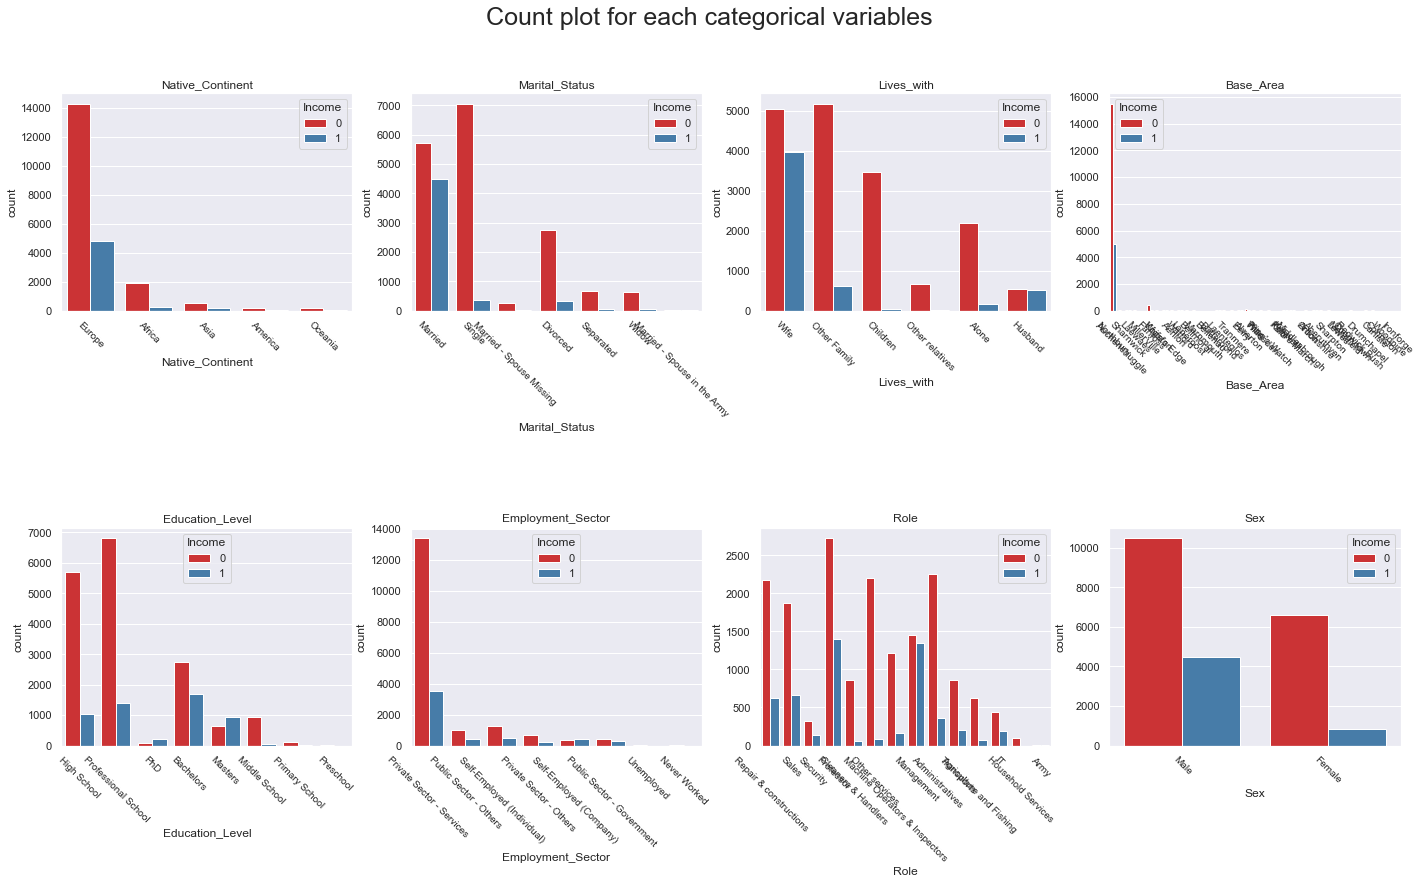

In [93]:
# Plot transformed data
sns.set()
fig, axes = plt.subplots(2,4, constrained_layout=True, figsize=(24,12))

fig.suptitle("Count plot for each categorical variables\n", fontsize=25)

for col, ax in zip(df[categorical].columns, axes.flatten()):
    sns.countplot(x=col, hue="Income", data=df, palette="Set1",ax=ax)
    ax.tick_params(axis='x',labelsize = 'small', labelrotation=-45) 
    ax.set_title(col)
    
# Just appear labels on outside axes
fig.subplots_adjust(hspace=1)
plt.show()

## Split data for modelling

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.3, stratify = df_Y, random_state=None)

## Apply OneHotEncoder to categorical data:

In [15]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(X_train[categorical])

ohc_feat_names = ohc.get_feature_names()

ohc_df = pd.DataFrame(ohc_feat, index=X_train.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?

# transfrom validation dataset
ohc_feat_test = ohc.transform(X_test[categorical])
ohc_df_test = pd.DataFrame(ohc_feat_test, index=X_test.index, columns=ohc_feat_names)

## Apply Min-Max scaler to numbercial features:

In [16]:
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
X_train[numercial] = scaler.fit_transform(X_train[numercial])
X_test[numercial] = scaler.transform(X_test[numercial])
X_train[numercial].head()

<ipython-input-16-fd1428d31a71>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numercial] = scaler.fit_transform(X_train[numercial])
C:\Users\Admin\anaconda3\envs\ML_Lab\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-16-fd1428d31a71>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

,Years_of_Education,Working_Hours_per_week,Money_Received,Ticket_Price,Sex,Age
3877,0.526316,0.275510,0.0,0.000000,1.0,0.493151
748,0.526316,0.346939,0.0,0.000000,0.0,0.438356
9562,1.000000,0.428571,0.0,0.453901,0.0,0.506849
6609,0.526316,0.397959,0.0,0.000000,0.0,0.506849
18863,0.526316,0.397959,0.0,0.000000,0.0,0.082192


In [17]:
# Reassigning df to contain ohc variables
X_train = pd.concat([X_train.drop(columns=categorical), ohc_df], axis=1)
X_test = pd.concat([X_test.drop(columns=categorical), ohc_df_test], axis=1)

In [18]:
X_train

,Years_of_Education,Working_Hours_per_week,Money_Received,Ticket_Price,Sex,Age,x0_America,x0_Asia,x0_Europe,x0_Oceania,...,x6_Household Services,x6_IT,x6_Machine Operators & Inspectors,x6_Management,x6_Other services,x6_Professor,x6_Repair & constructions,x6_Sales,x6_Security,x6_Transports
3877,0.526316,0.275510,0.0,0.000000,1.0,0.493151,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
748,0.526316,0.346939,0.0,0.000000,0.0,0.438356,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9562,1.000000,0.428571,0.0,0.453901,0.0,0.506849,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6609,0.526316,0.397959,0.0,0.000000,0.0,0.506849,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18863,0.526316,0.397959,0.0,0.000000,0.0,0.082192,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10712,0.684211,0.397959,0.0,0.000000,0.0,0.369863,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13541,0.578947,0.193878,0.0,0.000000,1.0,0.027397,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17629,0.578947,0.561224,0.0,0.000000,0.0,0.575342,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15622,0.578947,0.193878,0.0,0.000000,0.0,0.082192,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [19]:
X_test

,Years_of_Education,Working_Hours_per_week,Money_Received,Ticket_Price,Sex,Age,x0_America,x0_Asia,x0_Europe,x0_Oceania,...,x6_Household Services,x6_IT,x6_Machine Operators & Inspectors,x6_Management,x6_Other services,x6_Professor,x6_Repair & constructions,x6_Sales,x6_Security,x6_Transports
13930,0.526316,0.397959,0.076879,0.0,1.0,0.397260,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15237,0.578947,0.397959,0.000000,0.0,1.0,0.465753,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18731,0.526316,0.397959,0.000000,0.0,1.0,0.136986,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14860,0.736842,0.397959,0.000000,0.0,0.0,0.178082,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18046,0.421053,0.397959,0.000000,0.0,0.0,0.178082,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20648,0.526316,0.500000,0.000000,0.0,1.0,0.671233,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18415,0.578947,0.397959,0.000000,0.0,1.0,0.041096,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13079,0.578947,0.397959,0.040643,0.0,0.0,0.178082,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14604,0.684211,0.397959,0.000000,0.0,0.0,0.438356,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
log_model = LogisticRegression()
log_model.fit(X_train,y_train)

C:\Users\Admin\anaconda3\envs\ML_Lab\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Measure the accuracy of test set

In [27]:
y_train_predicted = log_model.predict(X_train)

In [28]:
confusion_matrix(y_train, y_train_predicted)

array([[11179,   783],
       [ 1602,  2116]], dtype=int64)

In [30]:
accuracy_score(y_train, y_train_predicted)

0.8478954081632653

In [31]:
precision_score(y_train, y_train_predicted)

0.7299068644360124

### Measure the accuracy of test set

In [21]:
y_predicted = log_model.predict(X_test)

In [22]:
confusion_matrix(y_test, y_predicted)

array([[4796,  331],
       [ 704,  889]], dtype=int64)

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [25]:
accuracy_score(y_test, y_predicted)

0.8459821428571429

In [26]:
precision_score(y_test, y_predicted)

0.728688524590164